# Notebook 1: Attention as Particle Dynamics

**Duration**: 2-3 hours  
**Prerequisites**: Notebook 0 (or equivalent understanding)

This notebook introduces the central metaphor of the Rigollet paper: **tokens are particles on a sphere**, and **attention creates forces between them**. We'll derive the fundamental equations and visualize the dynamics in 3D.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Interpret tokens as particles on a sphere
- [ ] Understand attention as an interaction force between particles
- [ ] Convert discrete layer updates to continuous-time dynamics
- [ ] Write down the SA and USA differential equations

---

## Key Insight for Your Work

Your ChemBERTa embeddings undergo ~6 iterations of this process. SapBERT undergoes ~12 iterations. The paper tells you what happens mathematically as tokens flow through these layers—they **cluster**.

In [2]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    project_to_sphere,
    orthogonal_projection,
    attention_weights,
    sa_velocity,
    usa_velocity,
    simulate_sa,
    simulate_usa,
    random_sphere_points,
    pairwise_similarity_dist,
    compute_cluster_metric,
    plot_sphere_3d,
    plot_similarity_evolution,
    run_interactive_simulation,
    SimulationResult
)

np.random.seed(42)
print("Imports loaded successfully!")

Imports loaded successfully!


---

## 1. The Particle Metaphor

### From Discrete Layers to Continuous Time

In a real transformer:
- Token embeddings are updated **discretely** at each layer
- With a residual connection: $x_{k+1} = x_k + \text{Attention}(x_k)$

The mean-field analysis treats this as a **continuous-time** process:
- Layer index $k$ → continuous time $t$
- Discrete update → differential equation: $\dot{x} = F(x)$

### Why the Sphere?

Layer normalization keeps embeddings bounded. The paper formalizes this by assuming:

$$x_i(t) \in \mathbb{S}^{d-1} = \{x \in \mathbb{R}^d : \|x\| = 1\}$$

Each token is a **particle on the unit sphere**, and attention determines how these particles move.

In [3]:
# Visualize particles on the 2-sphere (S²) in 3D

n_particles = 10
d = 3  # 3D for visualization

# Generate random particles on the sphere
X0 = random_sphere_points(n_particles, d, seed=42)

print(f"Generated {n_particles} particles on S² (the 2-sphere in 3D)")
print(f"Shape: {X0.shape}")
print(f"Norms (should all be 1): {np.linalg.norm(X0, axis=1)}")

Generated 10 particles on S² (the 2-sphere in 3D)
Shape: (10, 3)
Norms (should all be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# Create 3D visualization
fig = plot_sphere_3d(X0, title="Initial Particle Positions on S²")
fig.show()

---

## 2. Attention as Interaction Force

### The Core Idea

Attention creates an "attractive force" between similar particles:

1. Each particle $x_i$ computes attention weights $A_{ij}$ to all other particles
2. High similarity ($\langle x_i, x_j \rangle$ large) → high weight $A_{ij}$
3. The particle moves toward the **weighted average** of all particles
4. A projection keeps the particle on the sphere

### Attention Weights

$$A_{ij} = \frac{\exp(\beta \langle x_i, x_j \rangle)}{\sum_k \exp(\beta \langle x_i, x_k \rangle)}$$

This is exactly softmax attention with temperature $\beta$!

Attention weight matrix shape: (10, 10)
Row sums (should be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


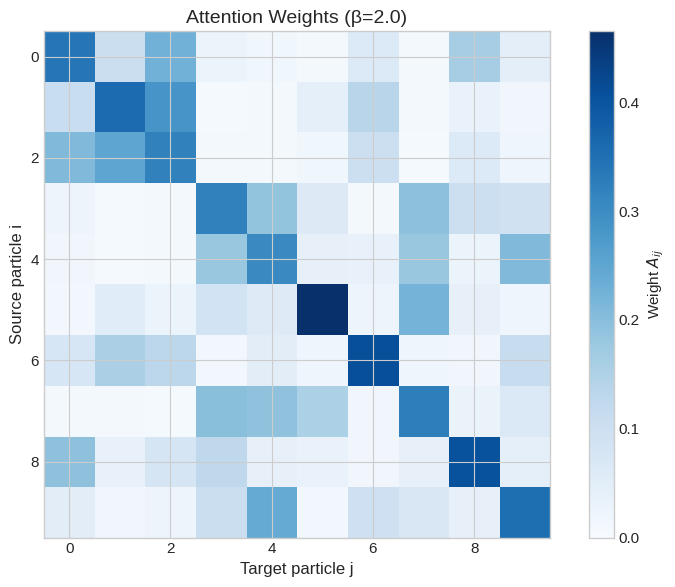


Diagonal is high because each particle has similarity 1 with itself.
Off-diagonal weights show inter-particle interactions.


In [5]:
# Compute attention weights for our particles

beta = 2.0
A = attention_weights(X0, beta, normalized=True)

print(f"Attention weight matrix shape: {A.shape}")
print(f"Row sums (should be 1): {A.sum(axis=1)}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(A, cmap='Blues', vmin=0)
ax.set_xlabel('Target particle j', fontsize=12)
ax.set_ylabel('Source particle i', fontsize=12)
ax.set_title(f'Attention Weights (β={beta})', fontsize=14)
plt.colorbar(im, ax=ax, label='Weight $A_{ij}$')
plt.tight_layout()
plt.show()

print("\nDiagonal is high because each particle has similarity 1 with itself.")
print("Off-diagonal weights show inter-particle interactions.")

In [6]:
# Show the weighted average direction for one particle

i = 0  # Focus on particle 0
weighted_avg = A[i] @ X0  # Weighted average of all particles

print(f"Particle {i} position: {X0[i]}")
print(f"Weighted average: {weighted_avg}")
print(f"\nThe particle will move toward this weighted average.")

# Visualize
fig = go.Figure()

# Add sphere wireframe
phi = np.linspace(0, 2*np.pi, 30)
theta = np.linspace(0, np.pi, 20)
phi, theta = np.meshgrid(phi, theta)
x_sphere = np.sin(theta) * np.cos(phi)
y_sphere = np.sin(theta) * np.sin(phi)
z_sphere = np.cos(theta)

fig.add_trace(go.Surface(
    x=x_sphere, y=y_sphere, z=z_sphere,
    opacity=0.1, showscale=False,
    colorscale=[[0, 'lightgray'], [1, 'lightgray']]
))

# Add all particles
fig.add_trace(go.Scatter3d(
    x=X0[:, 0], y=X0[:, 1], z=X0[:, 2],
    mode='markers',
    marker=dict(size=6, color='gray', opacity=0.5),
    name='Other particles'
))

# Highlight particle i
fig.add_trace(go.Scatter3d(
    x=[X0[i, 0]], y=[X0[i, 1]], z=[X0[i, 2]],
    mode='markers',
    marker=dict(size=10, color='blue'),
    name=f'Particle {i}'
))

# Show weighted average direction
fig.add_trace(go.Scatter3d(
    x=[weighted_avg[0]], y=[weighted_avg[1]], z=[weighted_avg[2]],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Weighted average'
))

# Arrow from particle to weighted average
fig.add_trace(go.Scatter3d(
    x=[X0[i, 0], weighted_avg[0]],
    y=[X0[i, 1], weighted_avg[1]],
    z=[X0[i, 2], weighted_avg[2]],
    mode='lines',
    line=dict(color='red', width=3),
    name='Direction of pull'
))

fig.update_layout(
    title=f'Particle {i} is "pulled" toward the weighted average',
    scene=dict(aspectmode='cube'),
    width=700, height=600
)
fig.show()

Particle 0 position: [ 0.23116514 -0.78895502  0.56930893]
Weighted average: [ 0.17257826 -0.56568392  0.27012177]

The particle will move toward this weighted average.


---

## 3. The Fundamental Equations

### Self-Attention (SA) Dynamics

The Self-Attention dynamics describe how particles evolve:

$$\dot{x}_i(t) = P^\perp_{x_i(t)} \left[ \frac{1}{Z_{\beta,i}} \sum_j \exp(\beta \langle x_i, x_j \rangle) x_j \right]$$

Where:
- $P^\perp_x y = y - \langle x, y \rangle x$ is the **orthogonal projection** onto the tangent space
- $Z_{\beta,i} = \sum_k \exp(\beta \langle x_i, x_k \rangle)$ is the softmax normalization
- The projection keeps particles on the sphere!

### Unnormalized Self-Attention (USA) Dynamics

A simpler variant without softmax normalization:

$$\dot{x}_i(t) = P^\perp_{x_i(t)} \left[ \frac{1}{n} \sum_j \exp(\beta \langle x_i, x_j \rangle) x_j \right]$$

### Key Difference

| SA | USA |
|----|----- |
| Weights sum to 1 | Weights sum to $\frac{1}{n}\sum_j e^{\beta\langle x_i, x_j\rangle}$ |
| Self-interaction fixed | Self-interaction depends on $\beta$ |
| Used in real transformers | Theoretically simpler |

In [7]:
# Demonstrate the orthogonal projection

def visualize_projection():
    """Show how projection keeps velocity tangent to sphere."""
    
    # A point on the sphere
    x = np.array([1.0, 0.0, 0.0])  # On the x-axis
    
    # Some arbitrary velocity vector (pointing outward)
    v = np.array([0.5, 0.3, 0.4])
    
    # Project onto tangent space
    v_tangent = orthogonal_projection(x, v)
    
    print(f"Point on sphere: x = {x}")
    print(f"Original velocity: v = {v}")
    print(f"Projected velocity: v_tangent = {v_tangent}")
    print(f"\n⟨x, v⟩ = {np.dot(x, v):.3f} (radial component removed)")
    print(f"⟨x, v_tangent⟩ = {np.dot(x, v_tangent):.6f} (should be ~0)")
    
    # Visualize
    fig = go.Figure()
    
    # Partial sphere
    phi = np.linspace(-np.pi/3, np.pi/3, 20)
    theta = np.linspace(np.pi/3, 2*np.pi/3, 20)
    phi, theta = np.meshgrid(phi, theta)
    xs = np.sin(theta) * np.cos(phi)
    ys = np.sin(theta) * np.sin(phi)
    zs = np.cos(theta)
    
    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs, opacity=0.3, showscale=False,
        colorscale=[[0, 'lightblue'], [1, 'lightblue']]
    ))
    
    # Point
    fig.add_trace(go.Scatter3d(
        x=[x[0]], y=[x[1]], z=[x[2]],
        mode='markers', marker=dict(size=10, color='blue'),
        name='Point x'
    ))
    
    # Original velocity
    scale = 0.5
    fig.add_trace(go.Scatter3d(
        x=[x[0], x[0]+scale*v[0]], y=[x[1], x[1]+scale*v[1]], z=[x[2], x[2]+scale*v[2]],
        mode='lines', line=dict(color='red', width=5),
        name='Original v (has radial component)'
    ))
    
    # Projected velocity
    fig.add_trace(go.Scatter3d(
        x=[x[0], x[0]+scale*v_tangent[0]], y=[x[1], x[1]+scale*v_tangent[1]], z=[x[2], x[2]+scale*v_tangent[2]],
        mode='lines', line=dict(color='green', width=5),
        name='Projected v (tangent to sphere)'
    ))
    
    # Radial direction
    fig.add_trace(go.Scatter3d(
        x=[0, x[0]], y=[0, x[1]], z=[0, x[2]],
        mode='lines', line=dict(color='gray', width=2, dash='dash'),
        name='Radial direction'
    ))
    
    fig.update_layout(
        title='Orthogonal Projection: Removing Radial Component',
        scene=dict(
            aspectmode='cube',
            xaxis=dict(range=[-0.5, 1.5]),
            yaxis=dict(range=[-0.5, 1]),
            zaxis=dict(range=[-0.5, 1])
        ),
        width=700, height=600
    )
    fig.show()

visualize_projection()

Point on sphere: x = [1. 0. 0.]
Original velocity: v = [0.5 0.3 0.4]
Projected velocity: v_tangent = [0.  0.3 0.4]

⟨x, v⟩ = 0.500 (radial component removed)
⟨x, v_tangent⟩ = 0.000000 (should be ~0)


In [8]:
# Calculate velocities for all particles

beta = 2.0
V_sa = sa_velocity(X0, beta)
V_usa = usa_velocity(X0, beta)

print("Self-Attention velocities:")
print(f"  Shape: {V_sa.shape}")
print(f"  Magnitudes: {np.linalg.norm(V_sa, axis=1)}")

print("\nUnnormalized SA velocities:")
print(f"  Shape: {V_usa.shape}")
print(f"  Magnitudes: {np.linalg.norm(V_usa, axis=1)}")

print("\nVerify velocities are tangent to sphere (⟨x, v⟩ ≈ 0):")
print(f"  SA: {np.sum(X0 * V_sa, axis=1)}")
print(f"  USA: {np.sum(X0 * V_usa, axis=1)}")

Self-Attention velocities:
  Shape: (10, 3)
  Magnitudes: [0.11479577 0.23177565 0.06282269 0.16235927 0.10942443 0.22995692
 0.17368271 0.16693822 0.11356005 0.16329184]

Unnormalized SA velocities:
  Shape: (10, 3)
  Magnitudes: [0.24844339 0.47639982 0.14585629 0.37622011 0.26521344 0.36536118
 0.31267957 0.37984773 0.20757639 0.34122992]

Verify velocities are tangent to sphere (⟨x, v⟩ ≈ 0):
  SA: [-4.16333634e-17 -3.33066907e-16 -3.49113100e-17  2.42861287e-17
  1.52655666e-16  0.00000000e+00 -4.16333634e-17 -1.04083409e-17
 -7.63278329e-17  1.42572586e-17]
  USA: [-2.77555756e-17 -4.44089210e-16  1.68268177e-16 -6.93889390e-17
  4.51028104e-16  0.00000000e+00  6.93889390e-18  9.02056208e-17
 -9.71445147e-17 -9.10729825e-17]


---

## 4. Simulating the Dynamics

Now we'll solve the differential equations numerically and watch the particles evolve!

In [9]:
# Run a basic simulation

beta = 2.0
t_end = 10.0
n_steps = 100

# Simulate SA dynamics
times, trajectory = simulate_sa(X0, beta, t_span=(0, t_end), n_steps=n_steps)

print(f"Simulation complete!")
print(f"  Time span: [0, {t_end}]")
print(f"  Time steps: {len(times)}")
print(f"  Trajectory shape: {trajectory.shape} (steps, particles, dimensions)")

# Check clustering metric
initial_clustering = compute_cluster_metric(trajectory[0])
final_clustering = compute_cluster_metric(trajectory[-1])

print(f"\nClustering metric (avg pairwise similarity):")
print(f"  Initial: {initial_clustering:.4f}")
print(f"  Final: {final_clustering:.4f}")
print(f"  Change: {final_clustering - initial_clustering:+.4f}")

Simulation complete!
  Time span: [0, 10.0]
  Time steps: 100
  Trajectory shape: (100, 10, 3) (steps, particles, dimensions)

Clustering metric (avg pairwise similarity):
  Initial: -0.0936
  Final: 0.1322
  Change: +0.2258


In [10]:
# Visualize the trajectories on the sphere

fig = plot_sphere_3d(
    trajectory[-1],  # Final positions
    trajectories=trajectory,  # Full trajectories
    title=f"Particle Trajectories (β={beta}, t=0 to {t_end})"
)
fig.show()

print("\nObservation: Particles move toward each other and cluster!")
print("This is the fundamental prediction of the paper.")


Observation: Particles move toward each other and cluster!
This is the fundamental prediction of the paper.


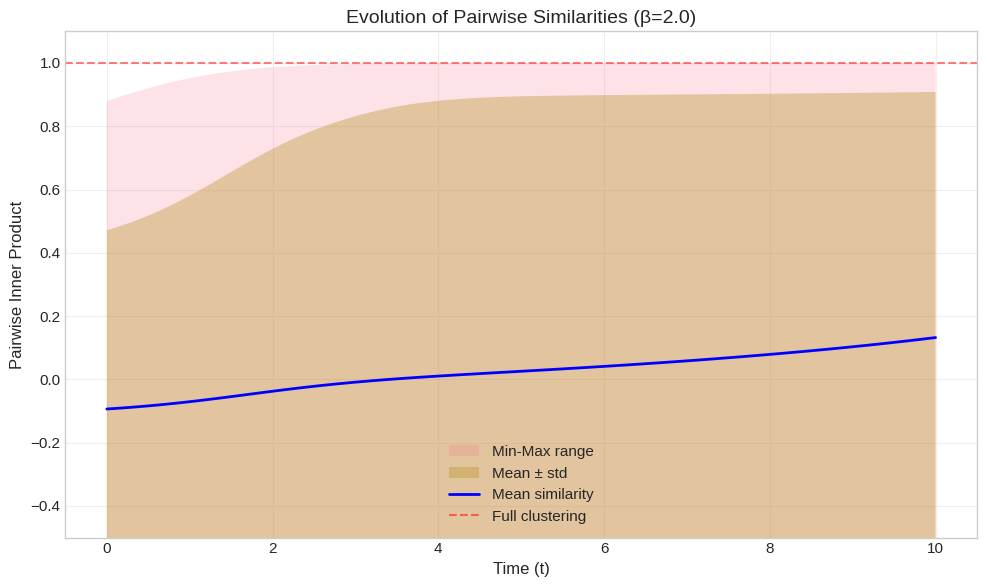

Key observations:
1. Mean similarity increases over time (particles cluster)
2. Variance decreases (similarities become more uniform)
3. Approaching 1.0 = all particles collapsing to same point


In [11]:
# Plot how pairwise similarities evolve over time

fig = plot_similarity_evolution(
    trajectory, times,
    title=f"Evolution of Pairwise Similarities (β={beta})"
)
plt.show()

print("Key observations:")
print("1. Mean similarity increases over time (particles cluster)")
print("2. Variance decreases (similarities become more uniform)")
print("3. Approaching 1.0 = all particles collapsing to same point")

---

## 5. Interactive Exploration

Use the widgets below to explore how different parameters affect the dynamics.

In [12]:
# Interactive simulation widget
from scipy.stats import gaussian_kde

def run_and_plot(n_particles, beta, t_end, dynamics_type):
    """Run simulation and create plots."""
    
    # Generate initial positions
    X0 = random_sphere_points(n_particles, 3, seed=42)
    
    # Run simulation
    if dynamics_type == 'SA':
        times, trajectory = simulate_sa(X0, beta, (0, t_end), n_steps=100)
    else:
        times, trajectory = simulate_usa(X0, beta, (0, t_end), n_steps=100)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Similarity evolution
    means = [np.mean(pairwise_similarity_dist(trajectory[i])) for i in range(len(times))]
    axes[0].plot(times, means, 'b-', linewidth=2)
    axes[0].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Time', fontsize=12)
    axes[0].set_ylabel('Mean Pairwise Similarity', fontsize=12)
    axes[0].set_title(f'{dynamics_type} Dynamics: n={n_particles}, β={beta}', fontsize=14)
    axes[0].set_ylim(-0.5, 1.1)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Initial vs Final distribution using KDE
    initial_sims = pairwise_similarity_dist(trajectory[0])
    final_sims = pairwise_similarity_dist(trajectory[-1])
    
    # Use KDE for smooth visualization (works better when particles cluster tightly)
    all_sims = np.concatenate([initial_sims, final_sims])
    x_range = np.linspace(min(-1, all_sims.min() - 0.1), max(1, all_sims.max() + 0.1), 200)
    
    kde_initial = gaussian_kde(initial_sims)
    kde_final = gaussian_kde(final_sims)
    
    axes[1].fill_between(x_range, kde_initial(x_range), alpha=0.5, label='Initial')
    axes[1].fill_between(x_range, kde_final(x_range), alpha=0.5, label='Final')
    axes[1].set_xlabel('Pairwise Similarity', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title('Distribution Shift', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary stats
    print(f"\nSummary:")
    print(f"  Initial mean similarity: {np.mean(initial_sims):.4f}")
    print(f"  Final mean similarity: {np.mean(final_sims):.4f}")
    print(f"  Clustering increase: {np.mean(final_sims) - np.mean(initial_sims):+.4f}")

# Create widgets
n_widget = widgets.IntSlider(value=10, min=3, max=30, step=1, description='Particles:')
beta_widget = widgets.FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='β:')
t_widget = widgets.FloatSlider(value=10.0, min=1.0, max=50.0, step=1.0, description='Time:')
dynamics_widget = widgets.Dropdown(options=['SA', 'USA'], value='SA', description='Dynamics:')

widgets.interact(
    run_and_plot,
    n_particles=n_widget,
    beta=beta_widget,
    t_end=t_widget,
    dynamics_type=dynamics_widget
)

interactive(children=(IntSlider(value=10, description='Particles:', max=30, min=3), FloatSlider(value=2.0, des…

<function __main__.run_and_plot(n_particles, beta, t_end, dynamics_type)>

---

## 6. SA vs USA Comparison

Let's directly compare the two dynamics to see their differences.

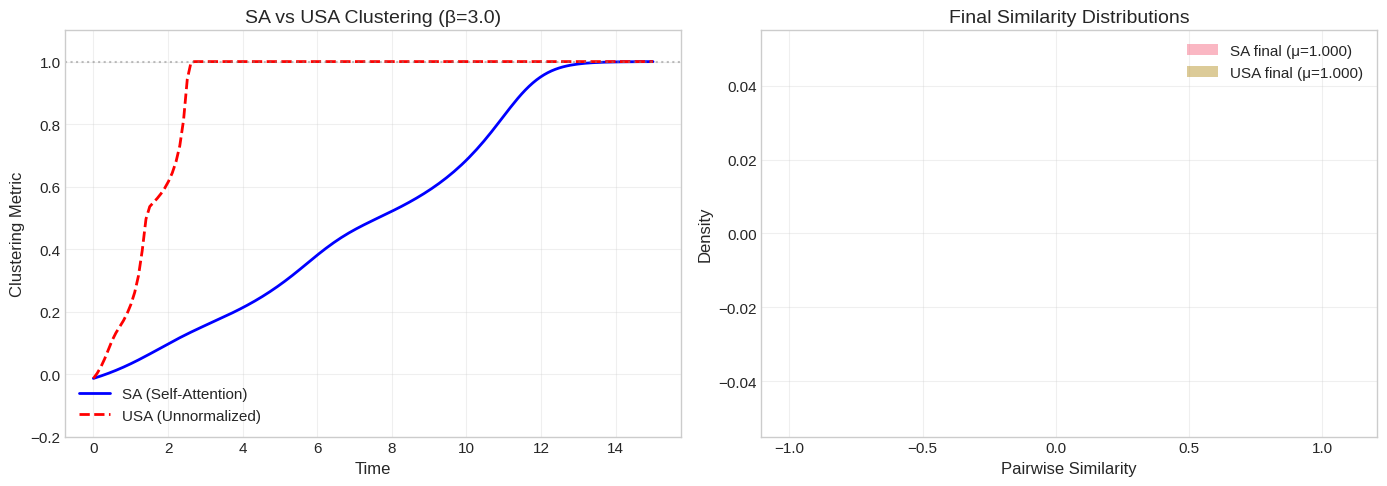

Observations:
  SA final clustering: 0.9998
  USA final clustering: 1.0000

Both dynamics lead to clustering, but at different rates!


In [13]:
# Compare SA and USA dynamics
from scipy.stats import gaussian_kde

# Same initial conditions
X0_comparison = random_sphere_points(15, 3, seed=123)
beta = 3.0
t_end = 15.0

# Run both
times_sa, traj_sa = simulate_sa(X0_comparison, beta, (0, t_end), n_steps=150)
times_usa, traj_usa = simulate_usa(X0_comparison, beta, (0, t_end), n_steps=150)

# Compute clustering metrics over time
clustering_sa = [compute_cluster_metric(traj_sa[i]) for i in range(len(times_sa))]
clustering_usa = [compute_cluster_metric(traj_usa[i]) for i in range(len(times_usa))]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clustering over time
axes[0].plot(times_sa, clustering_sa, 'b-', linewidth=2, label='SA (Self-Attention)')
axes[0].plot(times_usa, clustering_usa, 'r--', linewidth=2, label='USA (Unnormalized)')
axes[0].axhline(y=1.0, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Clustering Metric', fontsize=12)
axes[0].set_title(f'SA vs USA Clustering (β={beta})', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.2, 1.1)

# Final distributions - use KDE for smooth visualization
# (Histograms fail when particles cluster tightly, creating invisible single-bin spikes)
final_sims_sa = pairwise_similarity_dist(traj_sa[-1])
final_sims_usa = pairwise_similarity_dist(traj_usa[-1])

# Compute KDE for smooth density estimation
all_sims = np.concatenate([final_sims_sa, final_sims_usa])
x_range = np.linspace(min(-1, all_sims.min() - 0.1), max(1, all_sims.max() + 0.1), 200)

kde_sa = gaussian_kde(final_sims_sa)
kde_usa = gaussian_kde(final_sims_usa)

axes[1].fill_between(x_range, kde_sa(x_range), alpha=0.5, label=f'SA final (μ={np.mean(final_sims_sa):.3f})')
axes[1].fill_between(x_range, kde_usa(x_range), alpha=0.5, label=f'USA final (μ={np.mean(final_sims_usa):.3f})')
axes[1].set_xlabel('Pairwise Similarity', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Final Similarity Distributions', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations:")
print(f"  SA final clustering: {clustering_sa[-1]:.4f}")
print(f"  USA final clustering: {clustering_usa[-1]:.4f}")
print("\nBoth dynamics lead to clustering, but at different rates!")

---

## Summary: The Particle Dynamics Perspective

### What We've Learned

| Concept | Description |
|---------|-------------|
| **Particles on Sphere** | Tokens $x_i \in \mathbb{S}^{d-1}$ live on the unit sphere |
| **Attention = Interaction** | Softmax weights determine how particles influence each other |
| **SA Dynamics** | $\dot{x}_i = P^\perp_{x_i}[\sum_j A_{ij} x_j]$ with softmax normalization |
| **USA Dynamics** | Same but with $1/n$ normalization instead of softmax |
| **Projection** | $P^\perp_x$ keeps velocities tangent → particles stay on sphere |

### Key Observation

**Particles cluster!** Similar particles attract each other and eventually merge. This is the fundamental phenomenon that the next notebooks will analyze mathematically.

### Connection to Your Work

When your metabolite embeddings pass through transformer layers:
- Similar metabolites (sugars, lipids, etc.) are pulled together
- The dynamics create semantic clusters
- But eventually... everything would collapse to one point!

The paper explains **why clustering happens** (Notebook 2) and **why useful structure persists** (Notebook 3: Metastability).

---

## Next: Notebook 2 - The Clustering Theorem

We'll prove that clustering is inevitable (Theorem 1) and analyze the convergence rates.